**Introduction**

In July 2017, the government of India announced the implementation of the Goods and Services Tax (GST), which it claimed would remove inefficiencies and foster economic growth by increasing the revenue collected by the government. The GST system unified the decades-long system of multiple indirect taxes into a single, streamlined framework. The new system replaced the service tax, value-added tax, central excise duty, by the country and state wide GST. 

Nevertheless, the effectiveness of the GST system remains a subject of considerable debate, particularly with the MSMEs (Micro, Small, and Medium Enterprises), who have encountered compliance challenges and a decline in the ease of doing business.

In [1]:
#loading the packages
!pip install stargazer

  Using cached stargazer-0.0.7-py3-none-any.whl.metadata (6.3 kB)
Using cached stargazer-0.0.7-py3-none-any.whl (15 kB)


In [2]:
import pandas as pd
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from stargazer.stargazer import Stargazer
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

from matplotlib import style
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

from typing import List
from operator import add
from toolz import reduce, partial

from scipy.optimize import fmin_slsqp

%matplotlib inline

pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

**Research Question**

**In the context of the 2017 tax system change in India, we wish to see the impact of the implementation of a unified tax system on government revenue collection**

To evaluate the true effectiveness of the GST system, we conducted a difference-in-differences (DiD) analysis. In constructing the DiD model, we developed a synthetic control group, which serves as a benchmark for comparison against the treatment group, i.e. India, following the third quarter of 2017. We expect to see an initial decline in the revenue collection by the government owing to the difficulties faced by the MSMEs followed by a rise in revenue.


**Data**

For our analysis, we constructed our own dataset by utilizing the Bloomberg Terminal, the image for which are attached below.

Government revenue, policy rates, and inflation data were collected through the Economic Statistics Table (ECST) function, which provided access to economic indicators for individual countries. Using this function, we retrieved data for India, Brazil, South Africa, the Philippines, Thailand, and Vietnam. We chose the countries listed above as they do not have a unified tax systme and had no change in their tax system during the treatment period. 

As the raw data for each country was reported at varying frequencies, we employed the Economic Workbench (ECWB) tool to manipulate and standardize the data across all countries for the target period from the first quarter of 2013 to the fourth quarter of 2022. Specifically, we exported each country's data from the ECST function into the ECWB, where we applied the Aggregation transformation to consolidate the data into a single Excel file.



<div style="display: flex; justify-content: center;">

  <div style="text-align: center; margin-right: 30px;">
    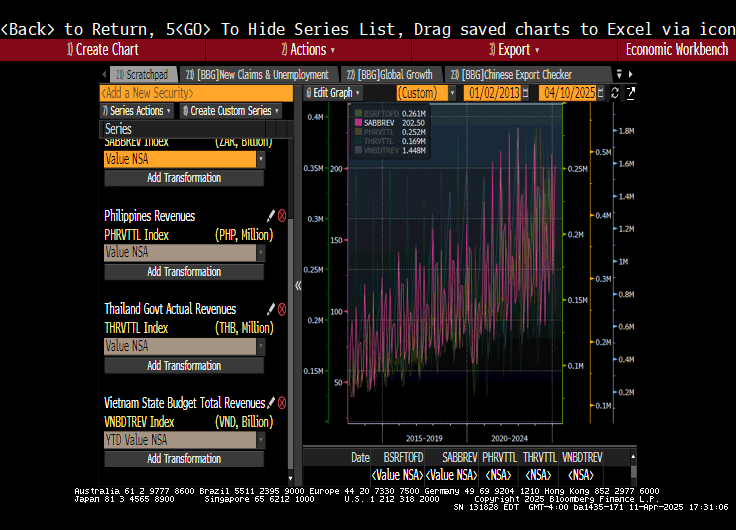
    <p style="margin-top: 5px;"><em>Figure 1: Revenue without Transformation</em></p>
  </div>

  <div style="text-align: center;">
    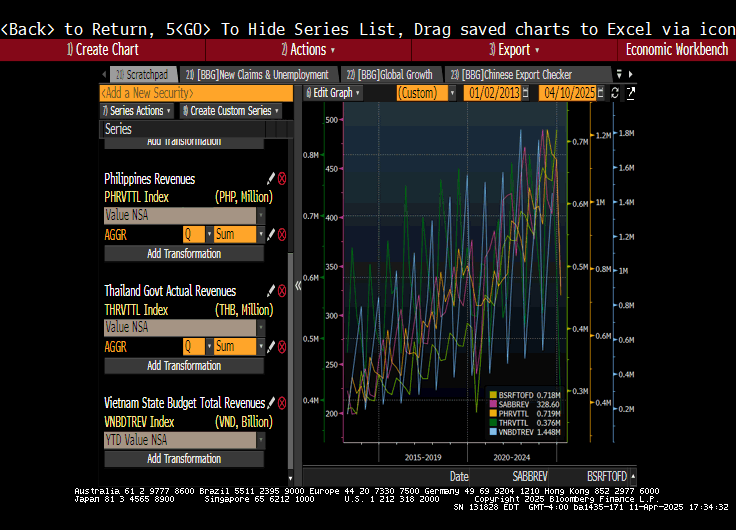
    <p style="margin-top: 5px;"><em>Figure 2: Revenue with Transformation</em></p>
  </div>

</div>


After the frequency check, we verified the dataset to ensure that all values were properly aggregated to the same set of quarterly periods. We used the summation method to maintain consistency across countries. This resulted in a panel dataset of quarterly government revenue, policy rates and inflation data for all selected countries.

Finally, to ensure comparability in the synthetic control construction and the difference-in-differences regression, applied the StandardScaler function to standaradise the all variables.

In [3]:
#loading and cleaning data

df = pd.read_csv("Project_data.csv")
df = df.rename(columns={"Country ":"Country"})
df.head()

,Time period,Quarters,Country,govt_rev,inflation,int_rate
0,2013,1,India,118458,2.1,8.7
1,2013,2,India,59022,2.5,8.3
2,2013,3,India,93702,3.6,9.9
3,2013,4,India,95179,1.8,8.8
4,2014,5,India,131575,-1.2,9.0


In [4]:
#standardizing the values

scaler = StandardScaler()
df[['int_rate', 'inflation','govt_rev']] = scaler.fit_transform(df[['int_rate', 'inflation', 'govt_rev']])
df.head()

,Time period,Quarters,Country,govt_rev,inflation,int_rate
0,2013,1,India,-0.925723,-0.370468,0.974355
1,2013,2,India,-1.050978,-0.212942,0.847962
2,2013,3,India,-0.977893,0.220255,1.353535
3,2013,4,India,-0.974781,-0.488613,1.005954
4,2014,5,India,-0.898080,-1.670059,1.069150


**Model**

The model employed in our analysis is a Difference-in-Differences (DiD) framework augmented with a synthetic control approach. The synthetic control method effectively constructs a counterfactual India, one without the implementation of the GST, by creating an artificial control group composed of a weighted combination of donor countries: Brazil, South Africa, the Philippines, Thailand, and Vietnam. This method is preferred over relying on a single control country, where establishing the parallel trends assumption proves challenging. By closely matching India’s pre-GST trends in government revenue (and, where applicable, other predictors such as inflation and policy rates), the synthetic control provides an estimate of what India's government revenues would have been in the absence of the GST reform, thereby constructing a credible counterfactual parallel trend. This significantly strengthens the validity and credibility of our model. 

In [5]:
#creating the time and treatment dummies for the DiD analysis

df['post'] = (df['Time period'] >= 2017).astype(int)
df['treatment'] = (df['Country'] == 'India').astype(int)
df['interaction'] = df['post'] * df['treatment']
df.head()

,Time period,Quarters,Country,...,post,treatment,interaction
0,2013,1,India,...,0,1,0
1,2013,2,India,...,0,1,0
2,2013,3,India,...,0,1,0
3,2013,4,India,...,0,1,0
4,2014,5,India,...,0,1,0


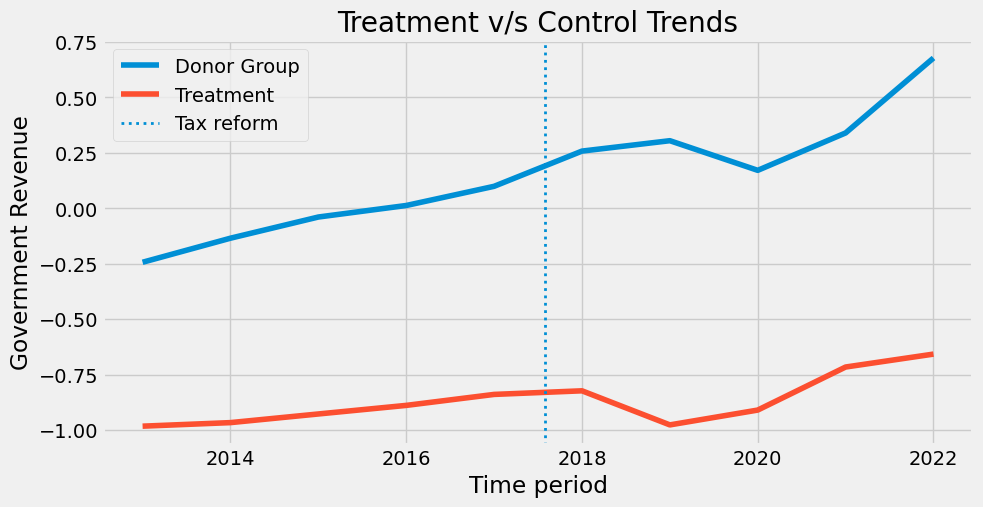

In [6]:
#grouping treatment and control groups by the time and treatment dummy and plotting it
ax = plt.subplot(1, 1, 1)

(df
 .assign(treatment = np.where(df["treatment"], "Treatment", "Donor Group"))
 .groupby(["Time period", "treatment"])
 ["govt_rev"]
 .mean()
 .reset_index()
 .pivot(index="Time period", columns="treatment", values="govt_rev")
 .plot(ax=ax, figsize=(10,5)))

plt.axvline(x=2017.58, linestyle=":", lw=2, label="Tax reform")
plt.ylabel("Government Revenue")
plt.title("Treatment v/s Control Trends")
plt.legend();

In [7]:
features = ["govt_rev", "inflation", "int_rate"]

inverted = (df[df["post"] == 0] 
            .pivot_table(index='Country', columns="Time period")['govt_rev']
            .T) 

inverted

Country,Brazil,India,Indonesia,...,South Africa,Thailand,Vietnam
Time period,,,,,,,
2013,-0.575635,-0.982343,1.094949,...,-1.174911,-0.038648,-0.493655
2014,-0.549491,-0.966305,1.241537,...,-1.174869,-0.081593,-0.073699
2015,-0.531791,-0.927315,1.438690,...,-1.174810,0.033324,0.063782
2016,-0.495776,-0.888623,1.532577,...,-1.174769,0.077233,0.156013


In [8]:
#creating treatment v/s control
y = inverted['India'].values # India
X = inverted.drop(columns = 'India').values  # Other countries

#regressing y on x to create the weights needed
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

#creating the synthetic control
synth_control = (df[df["treatment"] == 0]
                  .pivot_table(index='Time period', columns="Country")["govt_rev"].dot(weights_lr))
synth_control

Time period
2013   -0.982343
2014   -0.966305
2015   -0.927315
2016   -0.888623
2017   -0.866266
2018   -0.796277
2019   -0.762432
2020   -0.786945
2021   -0.643446
2022   -0.508139
dtype: float64

In [9]:
treatment = (df[df["treatment"] == 1]
                  .pivot_table(index='Time period', columns="Country")["govt_rev"])
treatment

Country,India
Time period,
2013,-0.982343
2014,-0.966305
2015,-0.927315
2016,-0.888623
2017,-0.839117
2018,-0.822887
2019,-0.976586
2020,-0.909708
2021,-0.715602


In [10]:
#creating a dataframe of the synthetic control and treatment columns

s = pd.Series(
    [-0.982343, -0.966305, -0.927315, -0.888623, -0.866266, -0.796277, -0.762432, -0.786945, -0.643446, -0.508139], 
    index=[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    name="Control"
)
control = s.reset_index()
control.columns = ["Time period", "Dummy India"]

merged_df = pd.merge(treatment.reset_index(), control, on='Time period')
print (merged_df)

   Time period     India  Dummy India
0         2013 -0.982343    -0.982343
1         2014 -0.966305    -0.966305
2         2015 -0.927315    -0.927315
3         2016 -0.888623    -0.888623
4         2017 -0.839117    -0.866266
5         2018 -0.822887    -0.796277
6         2019 -0.976586    -0.762432
7         2020 -0.909708    -0.786945
8         2021 -0.715602    -0.643446
9         2022 -0.657293    -0.508139


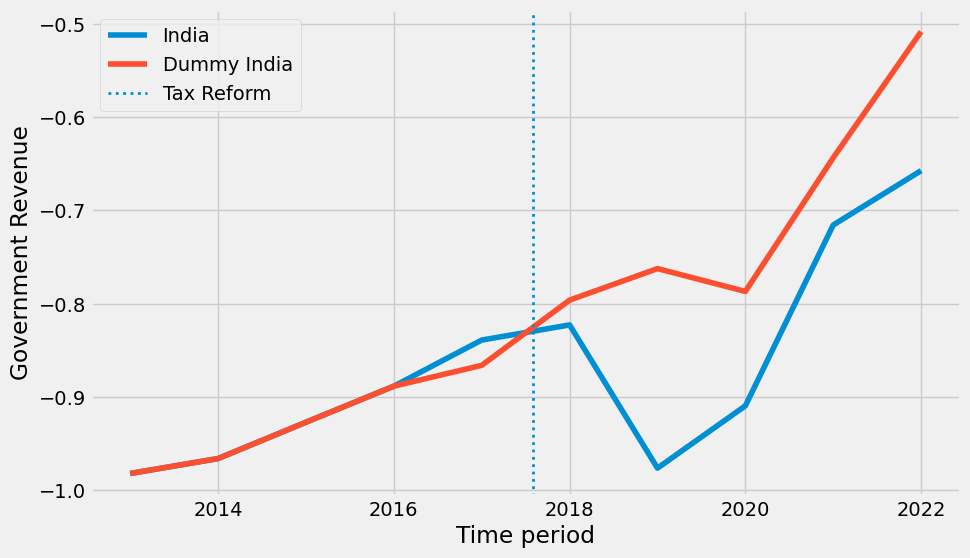

In [11]:
#plotting the treatment and synthetic control against each other to evaluate trends

plt.figure(figsize=(10,6))
plt.plot(merged_df["Time period"], merged_df["India"], label="India")
plt.plot(merged_df["Time period"], merged_df["Dummy India"], label="Dummy India")
plt.axvline(x=2017.58, linestyle=":", lw=2, label="Tax Reform")
plt.ylabel("Government Revenue")
plt.xlabel ("Time period")
plt.legend();

**Overfitting**

The graph above plots the revenue trends for the treatment and control groups. However as is evident from the graph and the table above, the revenue for the two groups for most of the observed period prior to the treatment (indicated by a vertical line in the graph) is exactly the same.

This indicates that there may be overfitting in the synthetic control as the weights chosen fit the treatment values onto the control exactly.

In order to counter this, instead of the new values, in the follwoing section, we choose weghts that follow a linear trend of the treatment values, creating a better control that eliminates the problem of overfitting.

This is done by minimising the distance, or RMSE, between the actual value and the weighted value that we estimate and eliminates any weight that might be negative.

In [12]:
#generating the new weights

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))
    
lambda x: np.sum(x) - 1

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

weights = get_w(X, y)
print("Sum:", weights.sum())
np.round(weights, 3)

Sum: 1.0


array([0.   , 0.   , 0.   , 0.793, 0.108, 0.099])

In [13]:
#creating the new synthetic control
new_synth = (df[df["treatment"] == 0]
                  .pivot_table(index='Time period', columns="Country")["govt_rev"].dot(weights))
new_synth

Time period
2013   -0.984947
2014   -0.947789
2015   -0.921713
2016   -0.907789
2017   -0.885820
2018   -0.852484
2019   -0.849555
2020   -0.857971
2021   -0.840895
2022   -0.785989
dtype: float64

In [14]:
#creating a dataframe of the new synthetic control and treatment columns

s2 = pd.Series(
    [-0.984947, -0.947789, -0.921713, -0.907789, -0.885820, -0.852484, -0.849555, -0.857971, -0.840895, -0.785989],
    index=[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    name="Control"
)
syn_control = s2.reset_index()
syn_control.columns = ["Time period", "Dummy India"]

merged = pd.merge(treatment.reset_index(), syn_control, on='Time period')

print(merged)

   Time period     India  Dummy India
0         2013 -0.982343    -0.984947
1         2014 -0.966305    -0.947789
2         2015 -0.927315    -0.921713
3         2016 -0.888623    -0.907789
4         2017 -0.839117    -0.885820
5         2018 -0.822887    -0.852484
6         2019 -0.976586    -0.849555
7         2020 -0.909708    -0.857971
8         2021 -0.715602    -0.840895
9         2022 -0.657293    -0.785989


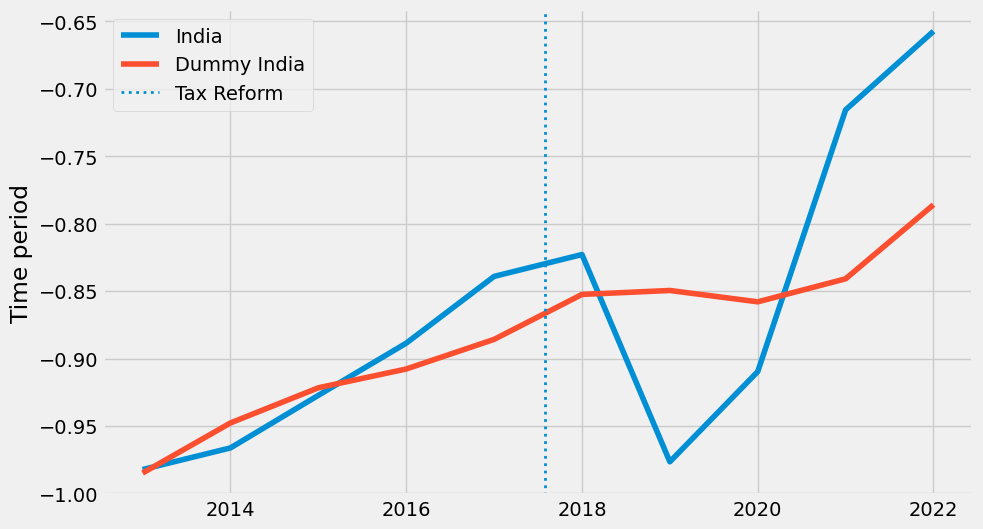

In [15]:
#plotting the new synthetic control against the treatment

plt.figure(figsize=(10,6))
plt.plot(merged["Time period"], merged["India"], label="India")
plt.plot(merged["Time period"], merged["Dummy India"], label="Dummy India")
plt.axvline(x=2017.58, linestyle=":", lw=2, label="Tax Reform")
plt.ylabel("Government Revenue")
plt.ylabel("Time period")
plt.legend();

**Data**

Now that we have our synthetic control, we will be using the weights generated to convert the data back into quarterly and add back inflation and interest rates to the dataframe. We will also be grouping according to unit and time fixed effects at this stage.

In [16]:
#converting yearly back to quaterly

quarterly_controls = df[df['Country'].isin(['Indonesia', 'Thailand', 'Brazil', 'South Africa', 'Vietnam', 'Phillipines'])]
quarterly_pivot = quarterly_controls.pivot_table(index='Quarters', columns='Country', values='govt_rev')

synthetic_quarterly = quarterly_pivot.values @ weights

synthetic_quarterly_df = pd.DataFrame({
    'Quarters': quarterly_pivot.index,
    'Synthetic India': synthetic_quarterly
})

print(synthetic_quarterly_df.tail())

    Quarters  Synthetic India
35        36        -0.725315
36        37        -0.948449
37        38        -0.799065
38        39        -0.747129
39        40        -0.649312


In [17]:
quarterly_controls2 = df[df['Country'].isin(['Indonesia', 'Thailand', 'Brazil', 'South Africa', 'Vietnam', 'Phillipines'])]
quarterly_pivot2 = quarterly_controls.pivot_table(index='Quarters', columns='Country', values='inflation')

synthetic_quarterly_inflation = quarterly_pivot2.values @ weights

synthetic_quarterly_inflation_df = pd.DataFrame({
    'Quarters': quarterly_pivot2.index,
    'Inflation Synthetic India': synthetic_quarterly_inflation
})

print(synthetic_quarterly_inflation_df.tail())

    Quarters  Inflation Synthetic India
35        36                   0.696234
36        37                   0.891608
37        38                   1.256536
38        39                   1.614475
39        40                   1.531524


In [18]:
quarterly_controls3 = df[df['Country'].isin(['Indonesia', 'Thailand', 'Brazil', 'South Africa', 'Vietnam', 'Phillipines'])]
quarterly_pivot3 = quarterly_controls.pivot_table(index='Quarters', columns='Country', values='int_rate')

synthetic_quarterly_interest = quarterly_pivot3.values @ weights

synthetic_quarterly_interest_df = pd.DataFrame({
    'Quarters': quarterly_pivot3.index,
    'Interest Synthetic India': synthetic_quarterly_interest
})

print(synthetic_quarterly_interest_df.tail())

    Quarters  Interest Synthetic India
35        36                 -0.704918
36        37                 -0.604687
37        38                 -0.479398
38        39                 -0.168765
39        40                  0.145667


In [19]:
treatment2 = (df[df["treatment"] == 1]
                  .pivot_table(index='Quarters', columns="Country", values=['govt_rev', 'inflation', 'int_rate']))
treatment2.tail()

,govt_rev,inflation,int_rate
Country,India,India,India
Quarters,,,
36,-0.651892,-0.449231,-0.415969
37,-0.627933,-1.197480,-0.415969
38,-0.718414,-0.173560,-0.194781
39,-0.654611,-0.646139,0.058005
40,-0.628216,-0.606757,0.247595


In [20]:
treatment2.columns = ['_'.join(col).strip() for col in treatment2.columns.values]

merge = pd.merge(treatment2, synthetic_quarterly_df, on='Quarters')
merge = pd.merge(merge, synthetic_quarterly_inflation_df, on='Quarters')
merge = pd.merge(merge, synthetic_quarterly_interest_df, on='Quarters')

merge.head()

,Quarters,govt_rev_India,inflation_India,...,Synthetic India,Inflation Synthetic India,Interest Synthetic India
0,1,-0.925723,-0.370468,...,-1.031802,0.984087,2.010901
1,2,-1.050978,-0.212942,...,-0.993168,0.938448,2.029489
2,3,-0.977893,0.220255,...,-1.018048,1.084836,1.903683
3,4,-0.974781,-0.488613,...,-0.896770,0.791934,1.649705
4,5,-0.898080,-1.670059,...,-1.034971,0.917733,1.392329


In [21]:
print (merge.columns)

Index(['Quarters', 'govt_rev_India', 'inflation_India', 'int_rate_India',
       'Synthetic India', 'Inflation Synthetic India',
       'Interest Synthetic India'],
      dtype='object')


In [22]:
# creating a stacked dataset

india = merge[['Quarters', 'govt_rev_India', 'inflation_India', 'int_rate_India']].copy()
india['unit_id'] = 'India'
india = india.rename(columns={
    'govt_rev_India': 'govt_rev',
    'inflation_India': 'inflation',
    'int_rate_India': 'int_rate'
})


synthetic = merge[['Quarters', 'Synthetic India', 'Inflation Synthetic India', 'Interest Synthetic India']].copy()
synthetic['unit_id'] = 'Synthetic India'
synthetic = synthetic.rename(columns={
    'Synthetic India': 'govt_rev',
    'Inflation Synthetic India': 'inflation',
    'Interest Synthetic India': 'int_rate'
})

stacked = pd.concat([india, synthetic], axis=0)

stacked

,Quarters,govt_rev,inflation,int_rate,unit_id
0,1,-0.925723,-0.370468,0.974355,India
1,2,-1.050978,-0.212942,0.847962,India
2,3,-0.977893,0.220255,1.353535,India
3,4,-0.974781,-0.488613,1.005954,India
4,5,-0.898080,-1.670059,1.069150,India
...,...,...,...,...,...
35,36,-0.725315,0.696234,-0.704918,Synthetic India
36,37,-0.948449,0.891608,-0.604687,Synthetic India
37,38,-0.799065,1.256536,-0.479398,Synthetic India
38,39,-0.747129,1.614475,-0.168765,Synthetic India


In [23]:
stacked['post'] = (df['Quarters'] >= 19).astype(int)
stacked['treatment'] = (df['Country'] == 'India').astype(int)
stacked['interaction'] = df['post'] * df['treatment']
stacked.head()

,Quarters,govt_rev,inflation,...,post,treatment,interaction
0,1,-0.925723,-0.370468,...,0,1,0
1,2,-1.050978,-0.212942,...,0,1,0
2,3,-0.977893,0.220255,...,0,1,0
3,4,-0.974781,-0.488613,...,0,1,0
4,5,-0.898080,-1.670059,...,0,1,0


In [24]:
stacked = stacked.rename (columns={
    'Quarters': 'time_id',
    'Country': 'unit_id',
    'interaction':'D'
})

**Regression**

The regression equation used is: $$
Government Revenue_{it} = \alpha_{it} + \gamma_{it} + \tau D_{it} + \beta_1 \text{Inflation}_{it} + \beta_2 \text{InterestRate}_{it} + \epsilon_{it}
$$

Where:

- $( \alpha_i )$: Country-specific fixed effects  
- $( \gamma_t )$: Time fixed effects 
- $( D_{it} )$: Treatment indicator (1 for India post-GST, 0 otherwise)  
- $( \tau )$: Coefficient of interest; measures the average treatment effect of GST  
- $( \beta_1, \beta_2 )$: Coefficients for inflation and interest rates, respectively  
- $( \varepsilon_{it} )$: Error term  

The controls account for macroeconomic conditions that may also influence government revenue, allowing for a cleaner estimate of GST's impact.


The regression used inflation adjusted interest rates as control. D is the dummy variable that shows the treatment effect. The coefficent of the treatment effect is tau, alpha and gamma show the time and unit fixed effects and beta1 and beta2 show the impact of the controls, inflation and central bank interest rates on government revenues.


In [25]:
model = smf.ols('govt_rev ~ C(unit_id) + C(time_id) + D + inflation + int_rate', data=stacked).fit(cov_type='HC1')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               govt_rev   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     25.46
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           1.27e-17
Time:                        21:59:30   Log-Likelihood:                 108.15
No. Observations:                  80   AIC:                            -130.3
Df Residuals:                      37   BIC:                            -27.87
Df Model:                          42                                         
Covariance Type:                  HC1                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [26]:
#cleaning up the results to hide fixed effects

results_df = pd.DataFrame({
    'coef': model.params,
    'std_err': model.bse,
    'pval': model.pvalues,
    })

important_vars = ['D', 'inflation', 'int_rate']  
clean_results = results_df.loc[important_vars]


print(clean_results)

               coef   std_err      pval
D          0.150644  0.082014  0.066239
inflation -0.088753  0.032069  0.005647
int_rate   0.029111  0.040213  0.469119


In [27]:
#converting results to a stargazer to see significance

stargazer = Stargazer([model])
stargazer.covariate_order(['D', 'inflation', 'int_rate'])

stargazer

In [30]:
# using the standard errors to visualise the treatment effect and the 95% confidence intervals

merged['Difference'] = merged['India'] - merged['Dummy India']

merged ['CI high'] = (merged ['Difference'] + (1.96 *  0.082014))
merged ['CI low'] = (merged ['Difference'] - (1.96 *  0.082014))

print(merged)

   Time period     India  Dummy India  Difference   CI high    CI low
0         2013 -0.982343    -0.984947    0.002604  0.163351 -0.158144
1         2014 -0.966305    -0.947789   -0.018516  0.142231 -0.179264
2         2015 -0.927315    -0.921713   -0.005602  0.155145 -0.166350
3         2016 -0.888623    -0.907789    0.019166  0.179913 -0.141582
4         2017 -0.839117    -0.885820    0.046703  0.207451 -0.114044
5         2018 -0.822887    -0.852484    0.029597  0.190344 -0.131150
6         2019 -0.976586    -0.849555   -0.127031  0.033716 -0.287778
7         2020 -0.909708    -0.857971   -0.051737  0.109011 -0.212484
8         2021 -0.715602    -0.840895    0.125293  0.286041 -0.035454
9         2022 -0.657293    -0.785989    0.128696  0.289443 -0.032052


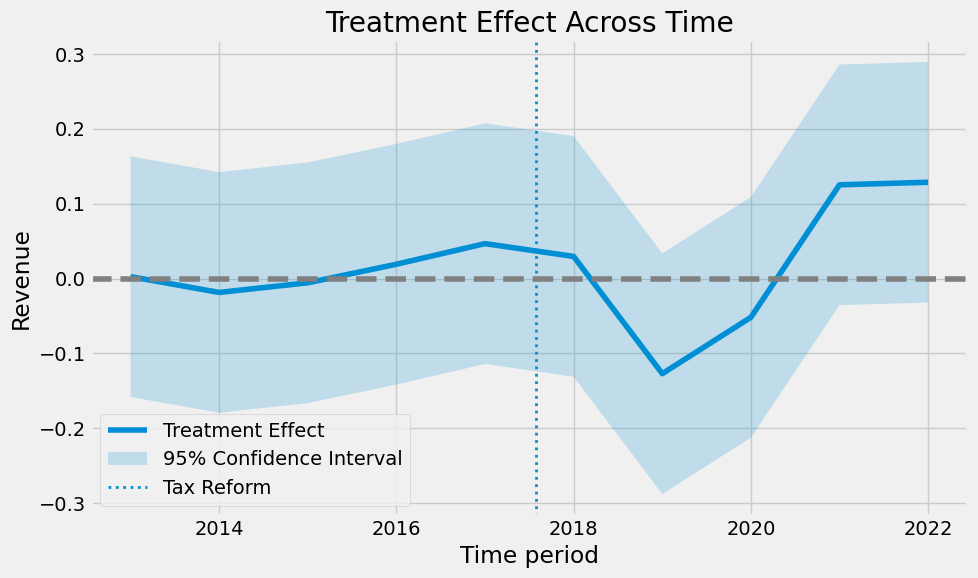

In [31]:
plt.figure(figsize=(10,6))
plt.plot(merged["Time period"], merged["Difference"],
         label="Treatment Effect")

plt.fill_between(merged["Time period"], 
                 merged ['CI high'], 
                 merged ['CI low'], 
                 alpha=0.2, label="95% Confidence Interval")


plt.axvline(x=2017.58, linestyle=":", lw=2, label="Tax Reform")
plt.title("Treatment Effect Across Time")
plt.ylabel("Revenue")
plt.xlabel("Time period")
plt.axhline(0, linestyle='--', color='grey')  
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Analysis**

There is strong evidence from the regression analysis that the Goods and Services Tax (GST) in India increased government revenue. In comparison to the synthetic control, the estimated treatment effect is 0.151, indicating a 15.1 percentage point increase in revenue. This finding provides moderate support for the idea that the GST increased tax collection by streamlining the system and broadening the tax base, even though it is only statistically significant at the 10% level (p = 0.066). It was discovered that inflation had a statistically significant and adverse impact on revenue, supporting the idea that rising inflation can reduce the actual value of tax revenues. In contrast, interest rates and revenue did not significantly correlate in the model.

But there are some issues, given the high number of fixed effects in relation to the sample size, the comparatively low adjusted $R^2$ (0.383) in comparison to the $R^2$ (0.711) raises the possibility of overfitting. Furthermore, the model makes the assumption that the treatment effect will be constant over time, which can ignore how the impact of GST has changed as implementation issues have been gradually resolved—a topic covered in more detail. However, since the average size of our prediction errors are small given the scaling, the findings are directionally consistent with the theory that the GST improved India's revenue results.


**Conclusion**

This study examined the impact of India’s 2017 Goods and Services Tax (GST) reform on government revenue using a combination of synthetic control and regression analysis. Our results suggest that GST had a positive and economically meaningful impact on revenue performance. Specifically, the synthetic control method showed a visible divergence in India’s post-GST revenue trajectory compared to the constructed counterfactual, while regression analysis estimated a 15.1 percentage point increase in revenue attributable to the reform. Although the statistical significance of this estimate was marginal (p ≈ 0.066)

After the GST was implemented we see a clear deviation of India's government revenue compared to the synthetic control. With tax collections falling for the immediate years of 2019 and then recovering in 2020. This was to be expected due to new compliance and other comprehensive requirements to be filled in tax returns for MSMEs. These processes made it significantly more costlier and time consuming to avail the benefits offered by the new tax regime (Kapparashetty 334). In response to these challenges, the 29th GST Council Meeting held in August 2018 was convened specifically to address MSME concerns and recommend measures to ease their compliance burden (“GST Council”).

Overall, the findings support prior studies showing enhanced tax collection and formalization under the new system and show a beneficial long-term impact of GST implementation on government revenue. Although there were noticeable short-term disruptions, especially for small enterprises, the reform eventually improved revenue mobilization and set the stage for a more cohesive and effective tax system.

**Citations**

Kapparashetty, B. V. "Impact of GST on MSMEs – An Overview." International Journal of Research and Analytical Reviews (IJRAR), vol. 5, no. 1, Mar. 2018, pp. 333–342. www.ijrar.org/IJRAR19D1325.pdf.

https://gstcouncil.gov.in/sites/default/files/2024-02/constitution_of_gom_for_msme_om_dt_14.08.2018.pdf